In [19]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import sys
import matplotlib.pyplot as plt

In [20]:
# Зададим размер батча для тренировки и тестирования сети
batch_size = 64
test_batch_size = 8

# Зададим необходимо количсетво эпох обучения
n_epochs = 2

# Задаем интервал логирования (количество батчей)
log_interval = 100

# Количество выходных классов (10 цифр)
num_classes = 10

# Зададим используемое для обучение устройство
device = torch.device("cpu")

In [21]:
# Предварительно вычисленные среднее и стандартное отколенение для датасета
data_mean = 0.131
data_std = 0.308

# Конвертируем входные изображения в тензоры и нормализуем их
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_mean,), (data_std,))
    ])

# Загружаем датасеты для тренировки и тестирования с применением трансформации
dtrain = datasets.MNIST('data', train=True, download=True, transform=transform)
dtest = datasets.MNIST('data', train=False, transform=transform)

# Задаем загружчики данных для обучения и тестирования
train_loader = torch.utils.data.DataLoader(dtrain,**{'batch_size': batch_size})
test_loader = torch.utils.data.DataLoader(dtest, **{'batch_size': test_batch_size})

In [22]:
# Задаем архитектуру нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.lin1(x)
        x = F.softmax(x, dim=1)
        return x

In [23]:
# Задаем типовой метод для обучения нейронной сети
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Эпоха обучения: {} [{}/{} ({:.0f}%)]\tПотери: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [24]:
# Задаем типовой метод для тестирования нейронной сети
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nТестовый набор данных: Средние потери: {:.5f}, Точность: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [25]:
# Передаем подготовленную модель на устройство (CPU)
model = Net().to(device)

In [26]:
optimizer = optim.Adadelta(model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.7)

# Обучаем модель
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
    scheduler.step()

Эпоха обучения: 1 [0/60000 (0%)]	Потери: 2.304737
Эпоха обучения: 1 [6400/60000 (11%)]	Потери: 1.592179
Эпоха обучения: 1 [12800/60000 (21%)]	Потери: 1.614126
Эпоха обучения: 1 [19200/60000 (32%)]	Потери: 1.596532
Эпоха обучения: 1 [25600/60000 (43%)]	Потери: 1.567868
Эпоха обучения: 1 [32000/60000 (53%)]	Потери: 1.636039
Эпоха обучения: 1 [38400/60000 (64%)]	Потери: 1.549205
Эпоха обучения: 1 [44800/60000 (75%)]	Потери: 1.579875
Эпоха обучения: 1 [51200/60000 (85%)]	Потери: 1.606577
Эпоха обучения: 1 [57600/60000 (96%)]	Потери: 1.570952

Тестовый набор данных: Средние потери: -0.90098, Точность: 9112/10000 (91%)

Эпоха обучения: 2 [0/60000 (0%)]	Потери: 1.522610
Эпоха обучения: 2 [6400/60000 (11%)]	Потери: 1.533939
Эпоха обучения: 2 [12800/60000 (21%)]	Потери: 1.548531
Эпоха обучения: 2 [19200/60000 (32%)]	Потери: 1.571769
Эпоха обучения: 2 [25600/60000 (43%)]	Потери: 1.539311
Эпоха обучения: 2 [32000/60000 (53%)]	Потери: 1.623466
Эпоха обучения: 2 [38400/60000 (64%)]	Потери: 1.509445

In [27]:
print(dtrain.targets)

tensor([5, 0, 4,  ..., 5, 6, 8])


In [28]:
def tohex(val, nbits):
  return hex((val + (1 << nbits)) % (1 << nbits))
def print_array(A, bits):
    for i in A:
        if (len(A.shape) > 1):
            for j in i:
                print(tohex(j, bits)[2:].zfill(bits//4), end=" ")
            print()
        else:
            print(tohex(i, bits)[2:].zfill(bits//4), end=" ")

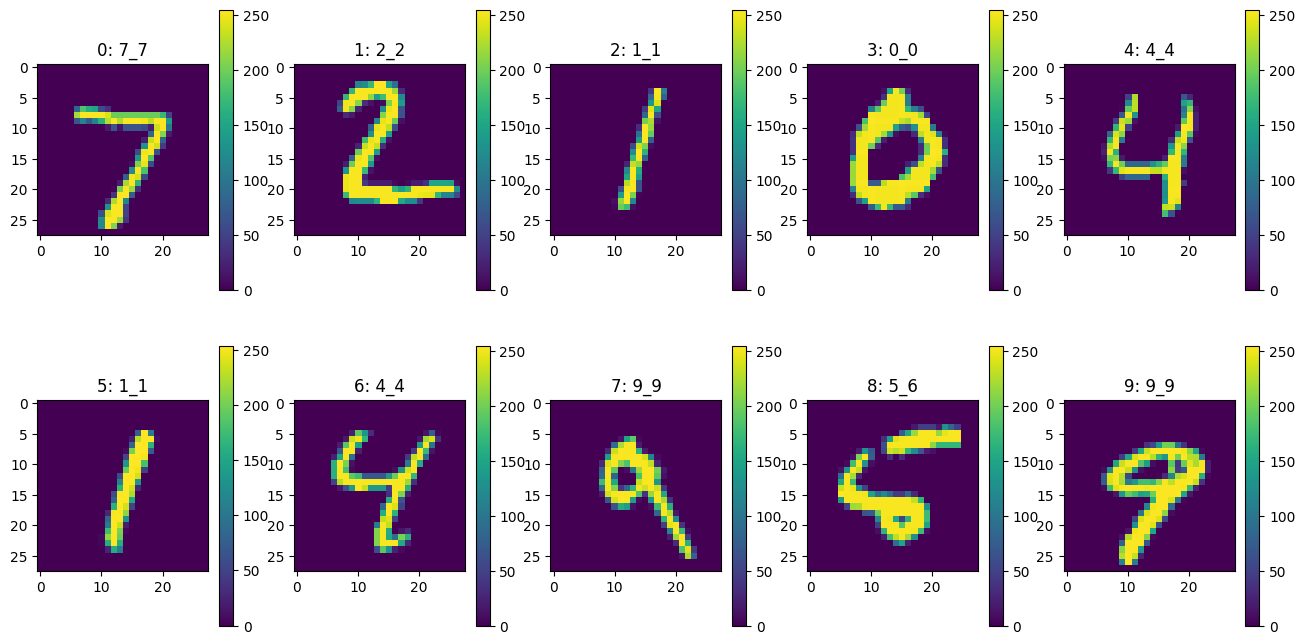

In [29]:
plt.figure(figsize=(16, 8))
for img in range(10):
  plt.subplot(2, 5, img+1)
  x_test = dtest.data[img, :, :]
  y_test = dtest.targets[img].detach().numpy()
  y_pred = model(dtest.data[img].to(torch.float32).to(device)).argmax().detach().numpy()
  plt.imshow(x_test)
  plt.title(str(img) + ": " + str(y_test) + "_" + str(y_pred))
  plt.colorbar()

In [30]:
images = [3, 2, 1, 18, 4, 15, 11, 0, 61, 9]
for i in range(len(images)):
  img = images[i]
  x_test = dtest.data[img, :, :]
  old_stdout = sys.stdout
  with open("image_{}.txt".format(i), "w") as sys.stdout:
    print_array(x_test.detach().numpy(), 16)
  sys.stdout = old_stdout

old_stdout = sys.stdout
with open("images.hex".format(i), "w") as sys.stdout:
  for i in range(len(images)):
    img = images[i]
    x_test = dtest.data[img, :, :]  
    print_array(x_test.detach().numpy(), 16)
sys.stdout = old_stdout

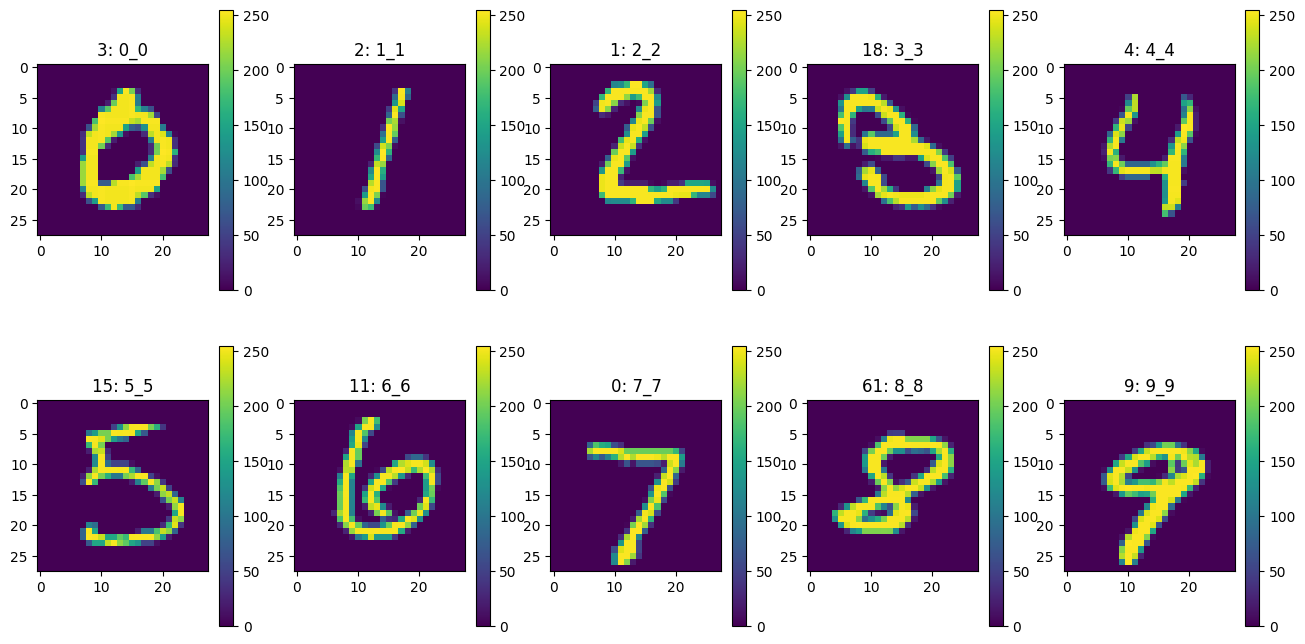

In [31]:
plt.figure(figsize=(16, 8))
for n in range(len(images)):
  plt.subplot(2, 5, n+1)
  img = images[n]
  x_test = dtest.data[img, :, :]
  y_test = dtest.targets[img].detach().numpy()
  y_pred = model(dtest.data[img].to(torch.float32).to(device)).argmax().detach().numpy()
  plt.imshow(x_test)
  plt.title(str(img) + ": " + str(y_test) + "_" + str(y_pred))
  plt.colorbar()

In [32]:
torch.save(model.state_dict(), "mnist_cnn_pytorch.ckpt")

In [33]:
def save(a, name):
    a = np.array(a) * 10000
    a = a.astype(np.int16)

    print('weight shape: ', a.shape)
    old_stdout = sys.stdout
    with open(name + ".txt", "w") as sys.stdout:
        for i in a:
            if (len(a.shape) > 1):
                for j in i:
                    print('{:d} '.format(j), end='')
                print()
            else:
                print('{:d} '.format(i), end='')
    sys.stdout = old_stdout

In [34]:
print(model.lin1.bias.detach().numpy())
save(model.lin1.bias.detach().numpy(), "bias")

[-0.02710535 -0.05143128 -0.02190416  0.02627235 -0.04546384  0.02502983
  0.00664369 -0.00694721 -0.00579035  0.01375362]
weight shape:  (10,)


In [35]:
print(model.lin1.weight.detach().numpy().T)
save(model.lin1.weight.detach().numpy().T, "weight")

[[-0.02473686  0.0341017  -0.02882119 ...  0.03041994  0.04336445
  -0.01355106]
 [-0.02331343  0.00946352  0.01023317 ...  0.0231257   0.0161019
   0.02101669]
 [ 0.0263694   0.0601455   0.02026349 ...  0.03266598 -0.01906827
   0.01014714]
 ...
 [-0.02505617  0.05612665  0.01734794 ... -0.02444711 -0.02151395
  -0.02166105]
 [ 0.01681872  0.025297    0.01505924 ... -0.01367083  0.0438372
   0.00046049]
 [ 0.03096378  0.02027866  0.01880793 ...  0.01267333  0.00370237
  -0.02317055]]
weight shape:  (784, 10)


In [36]:
def read_save(name, transpose, bits):
    f = open(name + ".txt", "r")
    a = np.array([line.split() for line in f], dtype=np.float64)
    #print(np.amax(a))
    #a = a*(2**(data_width-1))/14600
    #print(np.amax(a))
    a = a.astype(np.int64)

    old_stdout = sys.stdout
    with open(name + ".hex.", "w") as sys.stdout:
        if (transpose):
            print_array(a.T, bits)
        else:
            print_array(a, bits)
    sys.stdout = old_stdout

read_save("weight", False, 16)
read_save("bias", False, 16)